# Forsøk: Hvordan varier ML-performance for de forskjellige sifrene?

## Hypotese: Det vil være lettere å klassifisere deweys dess flere siffer dem har, siden innholdet er mer spesifisert?

In [261]:
from nb_ml import utils_nb
import pandas as pd
folder = "/home/ubuntu/PycharmProjects_saved/tgpl_w_oop/data_set/tgcForOptimization/tgcForOptimization"
articles = utils_nb.get_articles_from_folder_several_deweys(folder)



# Oversikt over deweys og antall dokumenter per dewey
Det første steget er å få en oversikt over hvilke deweys vi har og hvor mange vi har av hver. For å få et inntrykk så skriver vi ut en liste over de 40 øverste. Dette vil også gi oss en formening om hvilke 3,4, 5 og 6 sifrede deweys som kan være aktuelle for videre forsøk.


In [262]:
topN = articles["dewey"].value_counts().head(60)
print("dewey       frekvens")
print(topN)


dewey       frekvens
36229         604
839823        141
362293        137
3621          129
3622          126
34304         116
3627          100
362204         96
6168915        90
351481         90
362292         79
30223          75
306            70
34602          58
379481         58
3412422        57
61092          56
34705          54
34206          53
9072           53
34306          53
75981          52
657            51
34401          48
3521409481     47
30712          47
34606          47
0014           46
37817          45
30542          44
3637387        44
327481         44
61612          44
36211068       44
341481         43
34202          42
34603          42
33263          42
34604          42
610711         41
7114           40
331257         40
839821         40
34505          40
30072          39
193            39
61578          39
3523           39
6167           37
3058           36
3053           36
343055         35
610730711      34
3401           34
346043 

Fra tabellen over ser vi at vi har en rekke lovende kandidater for videre forsøk. Jeg lister dem opp ved siden av antall deweys, frekvens er i parentes:
- 10-siffer: 3521409481(47)

- 7-siffer: 6168915 (90), 3412422(57)
- 6-siffer: 839823 (141), 362293(137), 362204(96), 362292(79),379481(58)
- 5-siffer: 36229 (604), 34304(116), 30223(75), 34602(58)
- 4-siffer: 3621(129), 3622(126),3627(100), 34602(58),9072(53)
- 3-siffer: 306(70), 657(51)

# Scenarioer for testing
### Hovedscenario
- 3 vs 6

#### Ekstra-scenarioer
- 3 vs 5
- 3 vs 6
- 3 vs 7

### Teknisk oppsett
I testene har logistisk regresjon blitt brukt som klassifiseringsalgoritme, under ligger testkoden.

Biblioteker:
- NLTK
- sci-kit learn
- matplotlib
- numpy


In [263]:
import sys
sys.path.append('/home/ubuntu/PycharmProjects_saved/tgpl_w_oop/nb_ml')
from nb_ml import logreg
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score
import matplotlib.cm as cm
import numpy as np
from collections import OrderedDict
from sklearn.neighbors.classification import KNeighborsClassifier
class dewey_test():
    
    def __init__(self, data):
        self.corpus_dataframe = data.copy()
        self.filtered_corpus = []
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.model = None
        self.predictions = None
        self.results = None
        self.accuracy = None
    def preprocessing(self, numArticlesPerDewey=2, strict = False):
        filtered_texts = []
        if strict == True:
            self.getStrictArticleSelection(numArticlesPerDewey)
        for text in self.corpus_dataframe["text"].values:
            tokenized_text = word_tokenize(text = str(text), language = "norwegian")
        self.y_train = self.corpus_dataframe["dewey"].tolist()
        self.y_test = self.corpus_dataframe["dewey"].tolist()
    def splitToTrainingAndTest(self, stratified):
        x = self.corpus_dataframe["text"].tolist()
        y = self.corpus_dataframe["dewey"].tolist()
        if stratified == True:
            self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x, y,test_size = 0.2, stratify = y,random_state = 42)
        else:
            self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x, y,test_size = 0.2,random_state = 42)
    def fit(self):
        count_vectorizer = CountVectorizer(max_features = 10000)
        self.x_train = count_vectorizer.fit_transform(self.x_train)
        self.x_test = count_vectorizer.transform(self.x_test)
    def train(self):
        self.model = LogisticRegression() 
        self.model.fit(self.x_train, self.y_train)
    def predict(self):
        self.predictions = self.model.predict(self.x_test)
        self.results = classification_report(self.y_test, self.predictions)
        self.getAccuracy()
    def getAccuracy(self):
        self.accuracy = accuracy_score(self.y_test, self.predictions)
    def printResults(self):
        print(str(self.results) +"\n")
        print("Accuracy:"+ str(self.accuracy))
    
    def tsne(self):
        X_reduced = TruncatedSVD(n_components = 50, random_state=0).fit_transform(self.x_train)
        X_embedded = TSNE(n_components =2, perplexity = 40, random_state = 0).fit_transform(X_reduced)
        
        colors = cm.rainbow(np.linspace(0,1,len(set(self.y_train))))
        unique_labels = set(self.y_train)
        color_dictionary = dict(zip(unique_labels, colors))
        
        color_list = []
        for label in self.y_train:
            color_list.append(color_dictionary[str(label)])
        for i in range(0,len(self.y_train)):    
            plt.scatter(X_embedded[i,0], X_embedded[i,1], c = color_list[i],label = str(self.y_train[i]), 
                        cmap = "tab20b" )
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = OrderedDict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
        plt.title("TSNE-plot")
        plt.show()
    def getStrictArticleSelection(self, articlesPerDewey):
        np.random.seed(0)
        size = articlesPerDewey  # sample size
        replace = False  # with replacement
       
        self.corpus_dataframe =self.corpus_dataframe[self.corpus_dataframe['dewey'].isin(self.corpus_dataframe['dewey'].value_counts()[self.corpus_dataframe['dewey'].value_counts()>size-1].index)]
        fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace), :]
        self.corpus_dataframe = self.corpus_dataframe.groupby('dewey', as_index=False).apply(fn)
        
    def plotDecisionSurface(self):
        X_reduced = TruncatedSVD(n_components = 50, random_state=0).fit_transform(self.x_train)
        X_embedded = TSNE(n_components =2, perplexity = 40, random_state = 0).fit_transform(X_reduced)
        
        
        colors = cm.rainbow(np.linspace(0,1,len(set(self.y_train))))
        unique_labels = set(self.y_test)
        color_dictionary = dict(zip(unique_labels, colors))
        
        color_list = []
        for label in self.y_train:
            color_list.append(color_dictionary[str(label)])
                
        # create meshgrid
        resolution = 1000 # 100x100 background pixels
        X2d_xmin, X2d_xmax = np.min(X_embedded[:,0]), np.max(X_embedded[:,0])
        X2d_ymin, X2d_ymax = np.min(X_embedded[:,1]), np.max(X_embedded[:,1])
        xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

        # approximate Voronoi tesselation on resolution x resolution grid using 1-NN
        background_model = KNeighborsClassifier(n_neighbors=1).fit(X_embedded, self.y_train) 
        voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
        voronoiBackground = voronoiBackground.reshape(xx.shape)
        
        plt.contourf(xx, yy, voronoiBackground, cmap=plt.cm.Paired)
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = OrderedDict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
        for i in range(0,len(self.y_train)):    
            plt.scatter(X_embedded[i,0], X_embedded[i,1], c = color_list[i],label = str(self.y_train[i]), 
                        cmap = "tab20b" )
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = OrderedDict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
        plt.title("Contour-diagram")
        #plt.scatter(X_embedded[:,0], X_embedded[:,1], c=self.y_train)
        plt.show()
        


In [264]:
## Hjelpefunksjoner
def getDeweyAndAllSubdeweys(deweynr, corpus):
    
    filter_col = [col for col in articles["dewey"] if col.startswith(deweynr)]
    dfWithDeweyAndSubdeweys = corpus.loc[corpus['dewey'].isin(filter_col)].copy()
    return dfWithDeweyAndSubdeweys

def sliceDewey(x,length):
    if len(x)==length:
        return x[:length]
    else:
        return x[:]
def joinDeweysDfs(*args):
    all_dfs = []
    for arg in args:
        all_dfs.append(arg)
    joined_df = pd.concat(all_dfs)
    return joined_df

# Offisiell Test 3 vs 6 siffer

## Deltest 1.1: 3 siffer   
Første test går ut på å gjøre en klassifisering med 39 dokumenter per dewey med deweyene 657, 306 og 193. Bakgrunnen for at 39 dokumenter er valgt er at dette er det høyeste antallet dokumenter vi kunne ha for å få 3 forskjellige deweys i testen. Dette gjenspeiles i listen over. Hver dewey har 39 dokumenter. 31 i treningssett og 8 i testsett.  

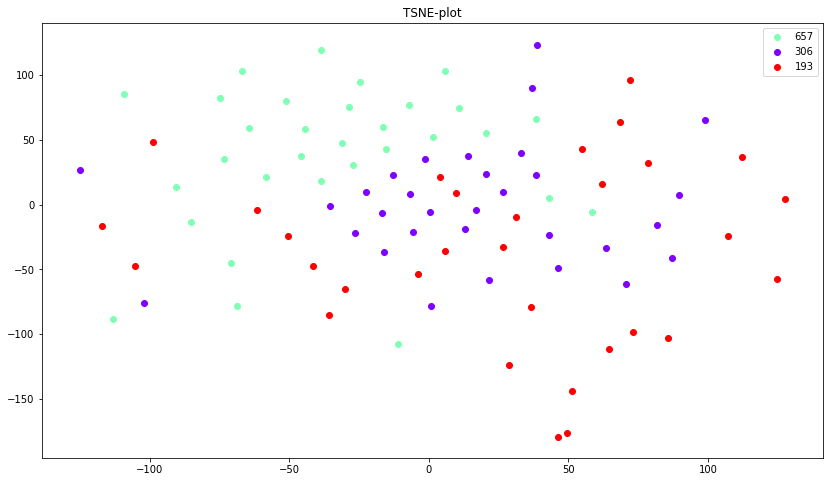

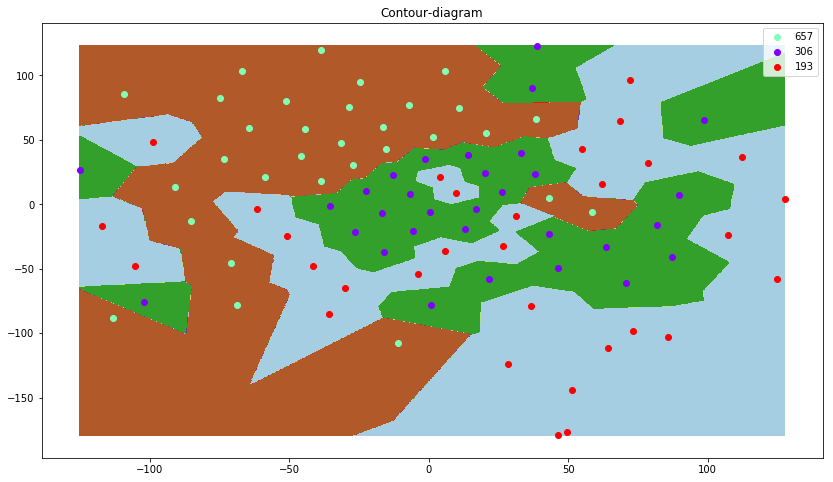

             precision    recall  f1-score   support

        193       0.88      0.88      0.88         8
        306       0.88      0.88      0.88         8
        657       1.00      1.00      1.00         8

avg / total       0.92      0.92      0.92        24


Accuracy:0.916666666667


In [265]:
test = dewey_test(dewey3_df)
test.preprocessing(numArticlesPerDewey=39, strict = True)
test.splitToTrainingAndTest(stratified = True)
test.fit()
test.train()
test.predict()
test.tsne()
test.plotDecisionSurface()
test.printResults()

## Deltest 1.2: 6 siffer, der alle siffer er fra samme subdewey, 362.
I denne testen brukes deweyene: 362293, 362292, 362204. Alle disse er fra samme subdewey 362. Hver dewey har 39 dokumenter. 31 i treningssett og 8 i testsett.

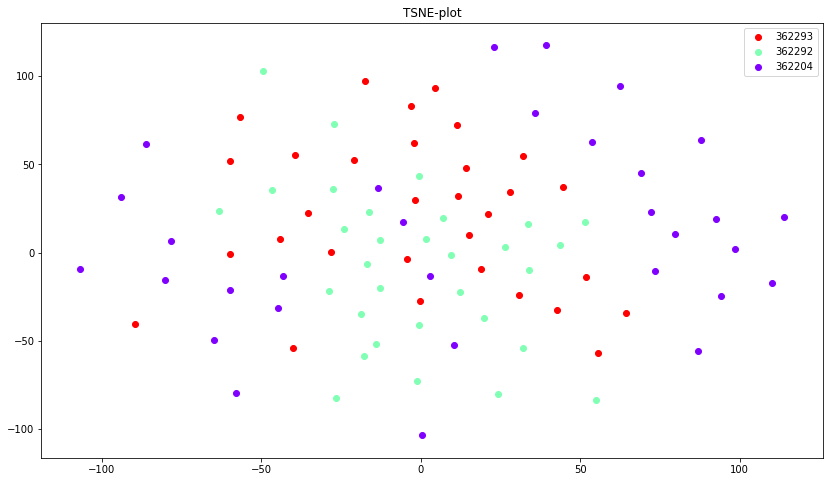

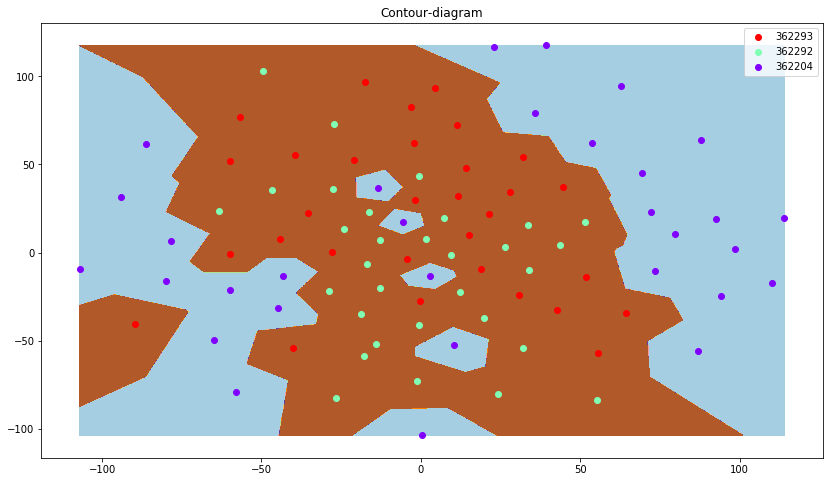

             precision    recall  f1-score   support

     362204       0.88      0.88      0.88         8
     362292       1.00      0.88      0.93         8
     362293       0.89      1.00      0.94         8

avg / total       0.92      0.92      0.92        24


Accuracy:0.916666666667


In [266]:
df_362 = getDeweyAndAllSubdeweys("362", articles)
mask = (df_362['dewey'].str.len() == 6)
df_362 = df_362.loc[mask]

test = dewey_test(df_362)
test.preprocessing(numArticlesPerDewey=39, strict = True)
test.splitToTrainingAndTest(stratified = True)
test.fit()
test.train()
test.predict()
test.tsne()
test.plotDecisionSurface()
test.printResults()

## Deltest 1.3: 6 siffer, der alle deweys er fra forskjellige subdeweys
I denne testen brukes deweyene: 839823, 379481, 327481. Disse er alle fra forskjellige subtre. Dette er for å se på hvordan dette påvirker gjenkjenningen til algoritmen, sammenlignet med testen gjort i deltest 1.2. Hver dewey har 39 dokumenter. 31 i treningssett og 8 i testsett.

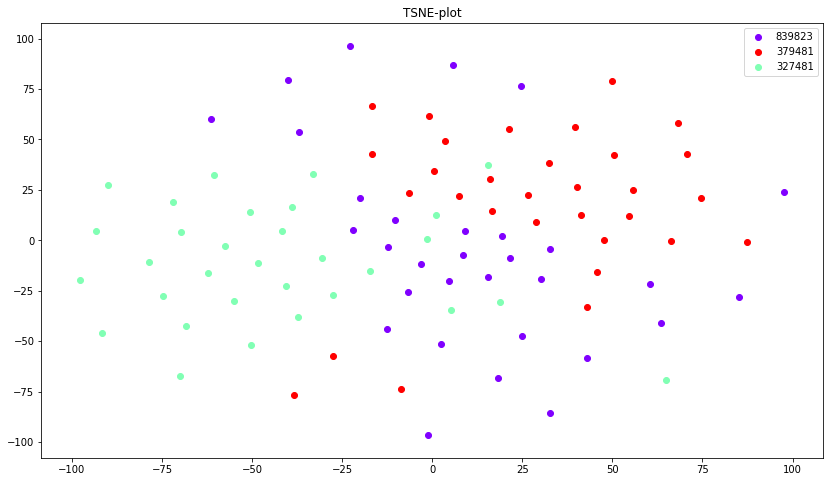

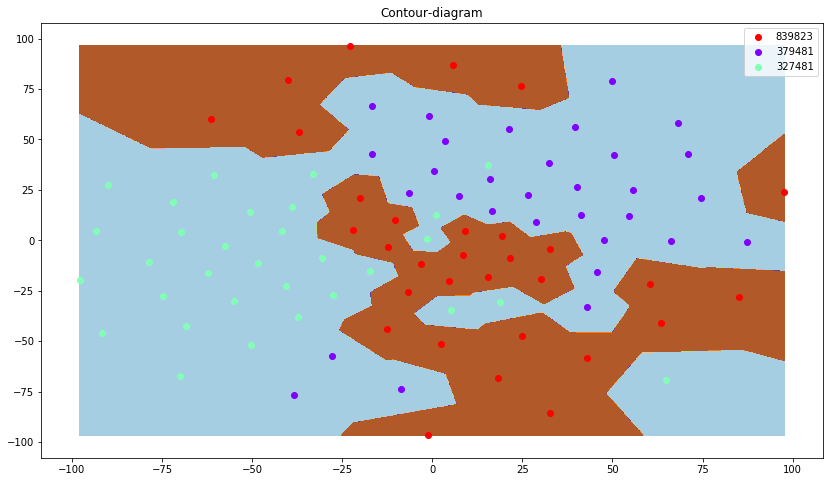

             precision    recall  f1-score   support

     327481       1.00      1.00      1.00         8
     379481       1.00      1.00      1.00         8
     839823       1.00      1.00      1.00         8

avg / total       1.00      1.00      1.00        24


Accuracy:1.0


In [267]:
df_839823 = getDeweyAndAllSubdeweys("839823", articles)
mask = (df_839823['dewey'].str.len() == 6)
df_839823 = df_839823.loc[mask]


df_379481 = getDeweyAndAllSubdeweys("379481", articles)
mask = (df_379481['dewey'].str.len() == 6)
df_379481= df_379481.loc[mask]

df_327481  = getDeweyAndAllSubdeweys("327481", articles)
mask = (df_327481 ['dewey'].str.len() == 6)
df_327481 = df_327481 .loc[mask]


joinedDF = pd.concat([df_839823, df_379481, df_327481])

test = dewey_test(joinedDF)
test.preprocessing(numArticlesPerDewey=39, strict = True)
test.splitToTrainingAndTest(stratified = True)
test.fit()
test.train()
test.predict()
test.tsne()
test.plotDecisionSurface()
test.printResults()

# 2: Ekstra tester
Dette er noen ekstra tester jeg har lagt inn, mens jeg har utforsket dataen. 
Her er det tester med 4,5 og 7 siffer. 

## Deltest 2.1: Test med 4 siffer:
Dette er en test av 4 sifrede deweys der alle er fra samme subdewey 3627. Deweyene som blir brukt er: 3627,3622,3621. Hver dewey har 39 dokumenter. 31 i treningssett og 8 i testsett.

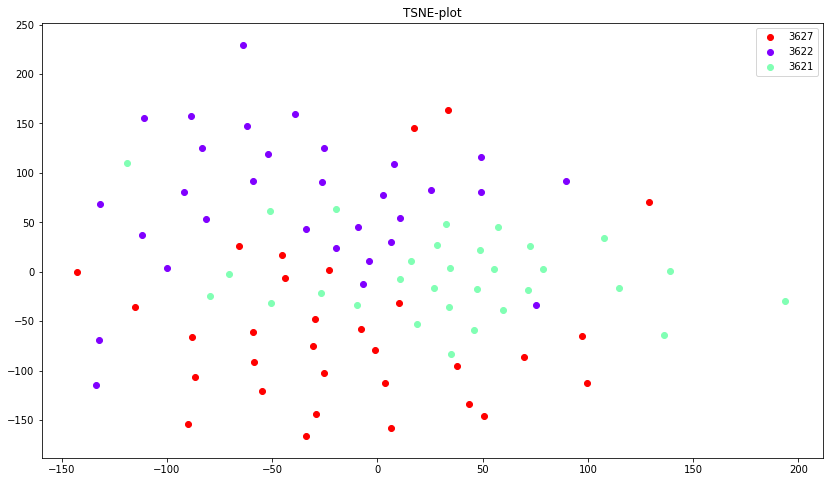

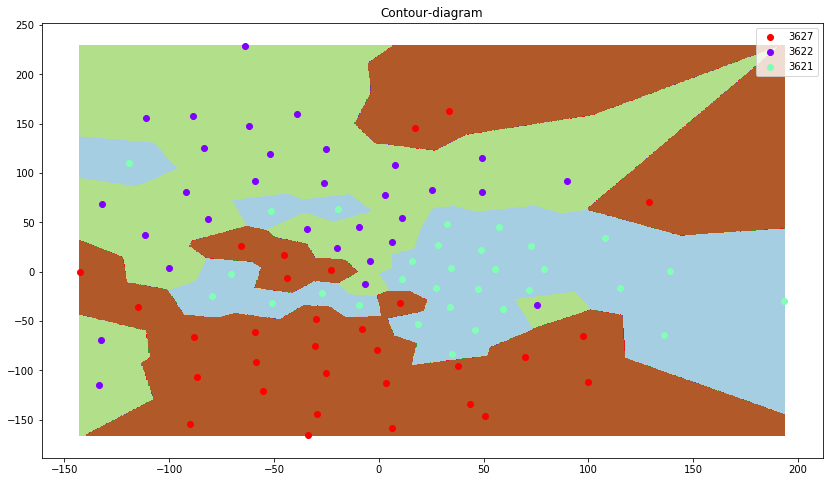

             precision    recall  f1-score   support

       3621       0.80      1.00      0.89         8
       3622       1.00      0.75      0.86         8
       3627       0.88      0.88      0.88         8

avg / total       0.89      0.88      0.87        24


Accuracy:0.875


In [268]:
dewey4 = ["3621", "3622", "3627"] #"9072"]
dewey4_df = articles.loc[articles['dewey'].isin(dewey4)].copy()

test = dewey_test(dewey4_df)
test.preprocessing(numArticlesPerDewey = 39, strict = True)
test.splitToTrainingAndTest(stratified = True)
test.fit()
test.train()
test.predict()
test.tsne()
test.plotDecisionSurface()
test.printResults()


## Deltest 2.2 Test med 5 siffer:
Test med 5 sifrede deweys der alle er fra forskjellige subdeweys. Deweyene som blir brukt her er: 30223,3403,36229 og 34602. Hver dewey har 39 dokumenter. 31 i treningssett og 8 i testsett.

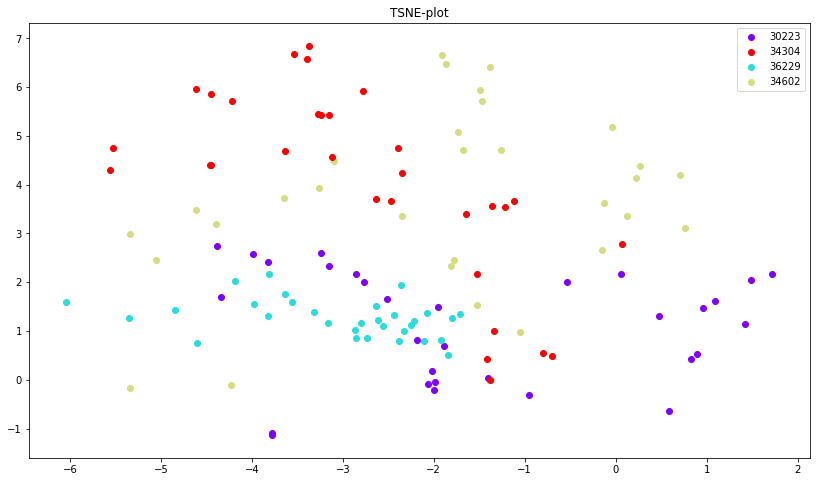

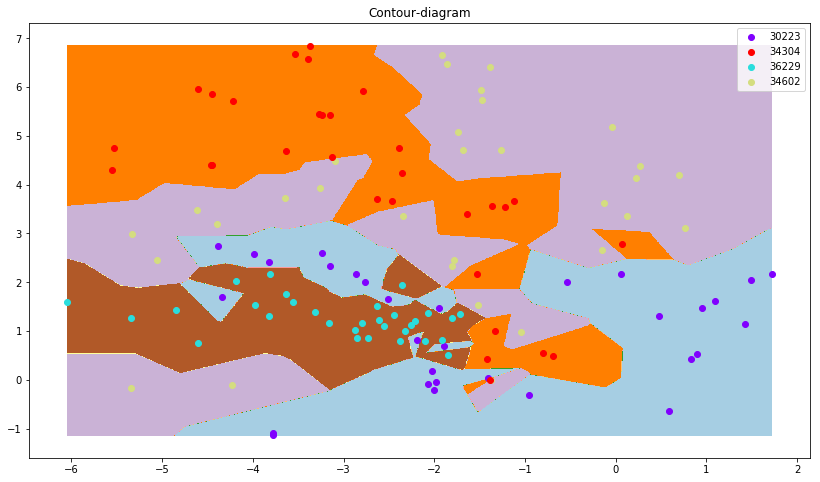

             precision    recall  f1-score   support

      30223       0.89      1.00      0.94         8
      34304       1.00      0.88      0.93         8
      34602       1.00      0.88      0.93         8
      36229       0.89      1.00      0.94         8

avg / total       0.94      0.94      0.94        32


Accuracy:0.9375


In [269]:
dewey5 = ["36229", "34304", "30223", "34602"]
dewey5_df = articles.loc[articles['dewey'].isin(dewey5)].copy()

test = dewey_test(dewey5_df)
test.preprocessing(numArticlesPerDewey = 39, strict = True)
test.splitToTrainingAndTest(stratified = True)
test.fit()
test.train()
test.predict()
test.tsne()
test.plotDecisionSurface()
test.printResults()

## Deltest 2.3 Test med 7 siffer:
Dette er en test med 2 forskjellige 7-sifrede deweys, der begge er fra forskjellige subdeweys. Deweyene som blir brukt er: 3412422 og 6168915. Hver dewey har 39 dokumenter. 31 i treningssett og 8 i testsett.

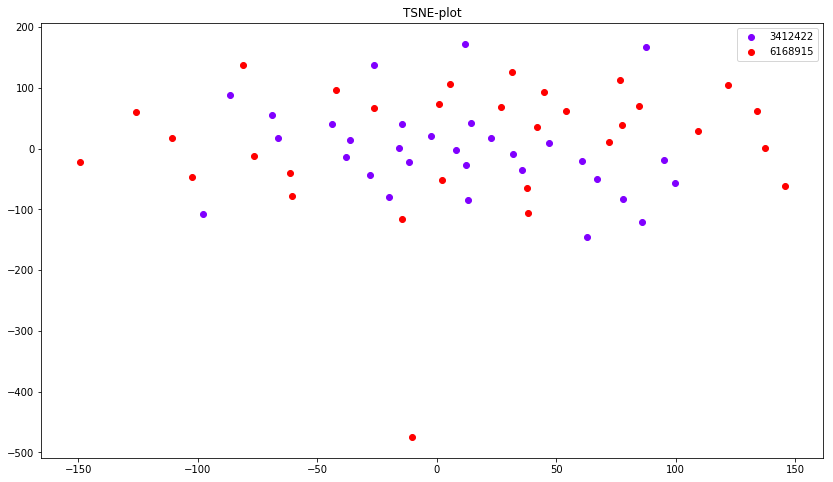

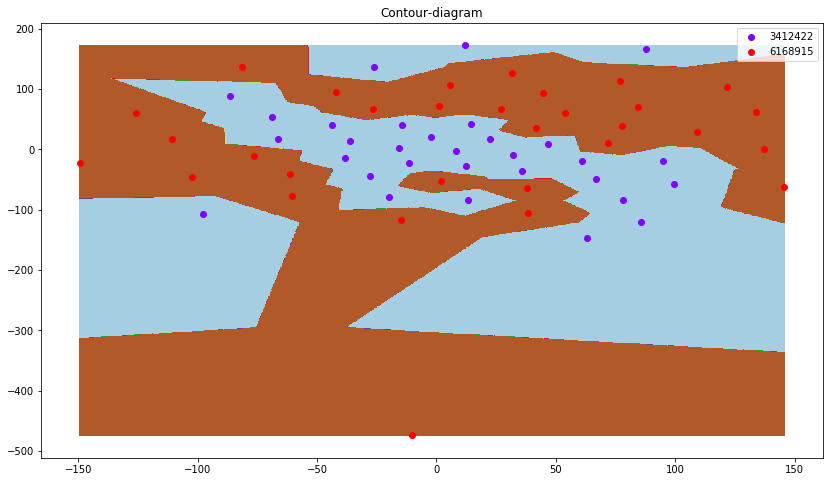

             precision    recall  f1-score   support

    3412422       1.00      1.00      1.00         8
    6168915       1.00      1.00      1.00         8

avg / total       1.00      1.00      1.00        16


Accuracy:1.0


In [270]:
dewey7 = ["6168915", "3412422"]
dewey7_df = articles.loc[articles['dewey'].isin(dewey7)].copy()

test = dewey_test(dewey7_df)
test.preprocessing(numArticlesPerDewey = 39, strict = True)
test.splitToTrainingAndTest(stratified = True)
test.fit()
test.train()
test.predict()
test.tsne()
test.plotDecisionSurface()
test.printResults()

# 3: Statistikk

In [271]:
dewey6 = ["839823", "362293", "362204", "362292", "379481"].copy()
dewey6_df = articles.loc[articles['dewey'].isin(dewey6)]

dewey5 = ["36229", "34304", "30223", "34602"]
dewey5_df = articles.loc[articles['dewey'].isin(dewey5)].copy()

dewey4 = ["3621", "3622", "3627", "9072"]
dewey4_df = articles.loc[articles['dewey'].isin(dewey4)].copy()




## Analyse av tekstlengde (i ord) og gjennomsnittlig ordlengde
For å forstå dataene bedre så vil jeg gjøre en analyse over tekstlengder og gjennomsnittlig ordlengde for de forskjellige deweyene. 


In [ ]:
## Importerer biblioteker. 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

### Deltest 1.1
Plot for deweyene brukt i test 1.1

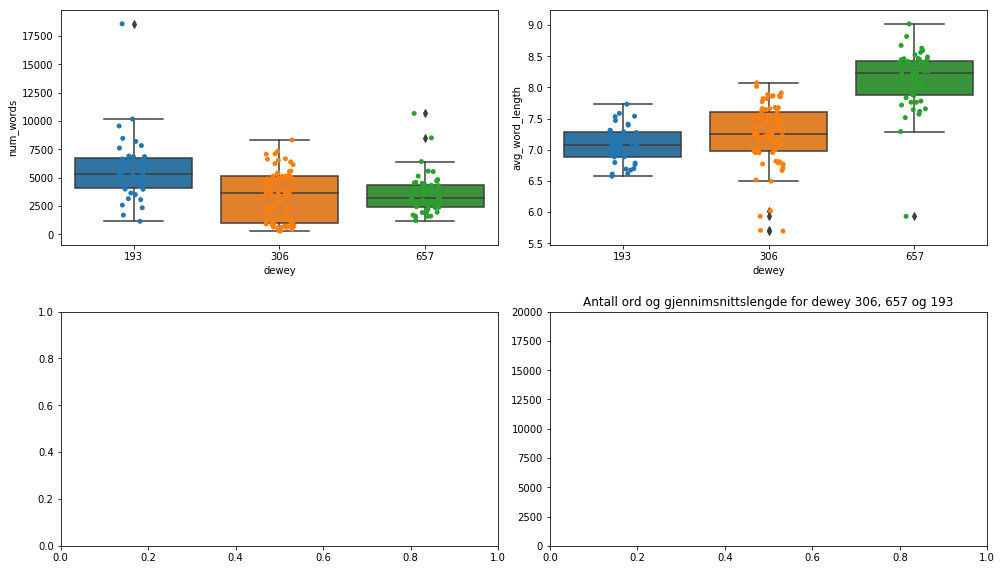

In [292]:
dewey3 = ["306", "657", "193"]

dewey3_df = articles.loc[articles['dewey'].isin(dewey3)].copy()
dewey3_df["num_words"] = dewey3_df["text"].str.split().str.len()



fig, axs = plt.subplots(nrows = 2, ncols=2, sharey = False)
plt.title("Antall ord og gjennimsnittslengde for dewey 306, 657 og 193")
sns.boxplot(x = "dewey", y = "num_words", data =dewey3_df, ax=axs[0,0])
sns.stripplot(x = "dewey", y = "num_words", data =dewey3_df, jitter = True,edgecolor= "yellow", ax=axs[0,0])

dewey3_df["char_length"] = dewey3_df["text"].str.strip().str.len()
dewey3_df["avg_word_length"] = dewey3_df["char_length"]/dewey3_df["num_words"]
sns.boxplot(x = "dewey", y = "avg_word_length", data =dewey3_df, ax=axs[0,1])
sns.stripplot(x = "dewey", y = "avg_word_length", data =dewey3_df, jitter = True,edgecolor= "yellow", ax=axs[0,1])

fig_size=[0,0]
fig_size[0] = 14
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
plt.ylim(0, 20000)
plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=2.0)
plt.show()

### Deltest 1.2
Plot av tekstlengde (ord) og gjennomsnittlig ordlengde for deweyene brukt i test 1.2

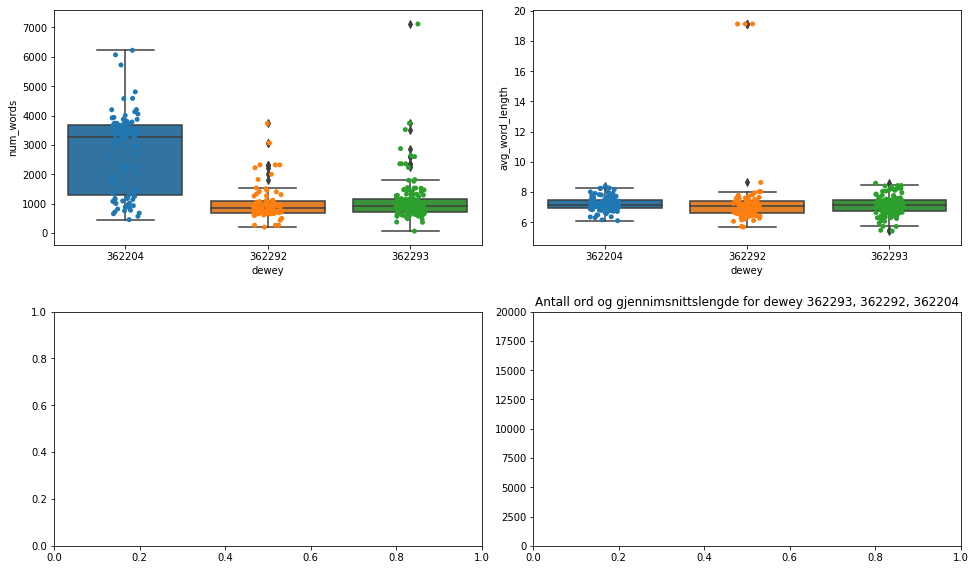

In [295]:
df_362_deweys = ["362293", "362292", "362204"]
df_362 = articles.loc[articles['dewey'].isin(df_362_deweys)].copy()
df_362["num_words"] = df_362["text"].str.split().str.len()

df_362["char_length"] = df_362["text"].str.strip().str.len()
df_362["avg_word_length"] = df_362["char_length"]/df_362["num_words"]

fig, axs = plt.subplots(nrows = 2, ncols=2, sharey = False)
plt.title("Antall ord og gjennimsnittslengde for dewey 362293, 362292, 362204")
sns.boxplot(x = "dewey", y = "num_words", data =df_362, ax=axs[0,0])
sns.stripplot(x = "dewey", y = "num_words", data =df_362, jitter = True,edgecolor= "yellow", ax=axs[0,0])

sns.boxplot(x = "dewey", y = "avg_word_length", data =df_362, ax=axs[0,1])
sns.stripplot(x = "dewey", y = "avg_word_length", data =df_362, jitter = True,edgecolor= "yellow", ax=axs[0,1])

fig_size=[0,0]
fig_size[0] = 14
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
plt.ylim(0, 20000)
plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=2.0)
plt.show()

### Deltest 1.3
Plot av tekstlengde (ord) og gjennomsnittlig ordlengde for deweyene brukt i test 1.3

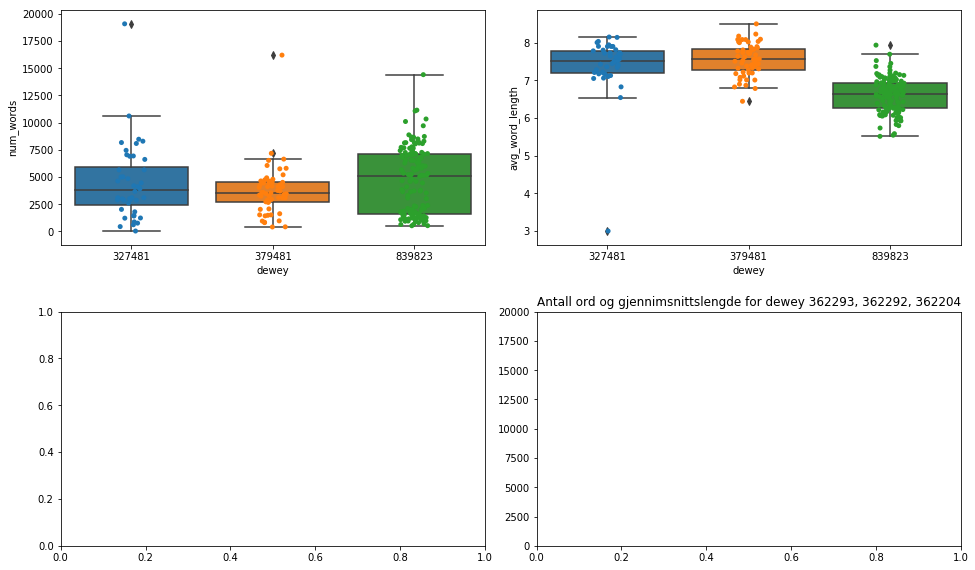

In [296]:
deweys13 = ["839823", "379481", "327481"]
df_1_3 = articles.loc[articles['dewey'].isin(deweys13)].copy()
df_1_3["num_words"] = df_1_3["text"].str.split().str.len()

df_1_3["char_length"] = df_1_3["text"].str.strip().str.len()
df_1_3["avg_word_length"] = df_1_3["char_length"]/df_1_3["num_words"]

fig, axs = plt.subplots(nrows = 2, ncols=2, sharey = False)
plt.title("Antall ord og gjennimsnittslengde for dewey 362293, 362292, 362204")
sns.boxplot(x = "dewey", y = "num_words", data =df_1_3, ax=axs[0,0])
sns.stripplot(x = "dewey", y = "num_words", data =df_1_3, jitter = True,edgecolor= "yellow", ax=axs[0,0])

sns.boxplot(x = "dewey", y = "avg_word_length", data =df_1_3, ax=axs[0,1])
sns.stripplot(x = "dewey", y = "avg_word_length", data =df_1_3, jitter = True,edgecolor= "yellow", ax=axs[0,1])

fig_size=[0,0]
fig_size[0] = 14
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
plt.ylim(0, 20000)
plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=2.0)
plt.show()

### Deltest 2.1
Plot av tekstlengde (ord) og gjennomsnittlig ordlengde for deweyene brukt i test 2.1

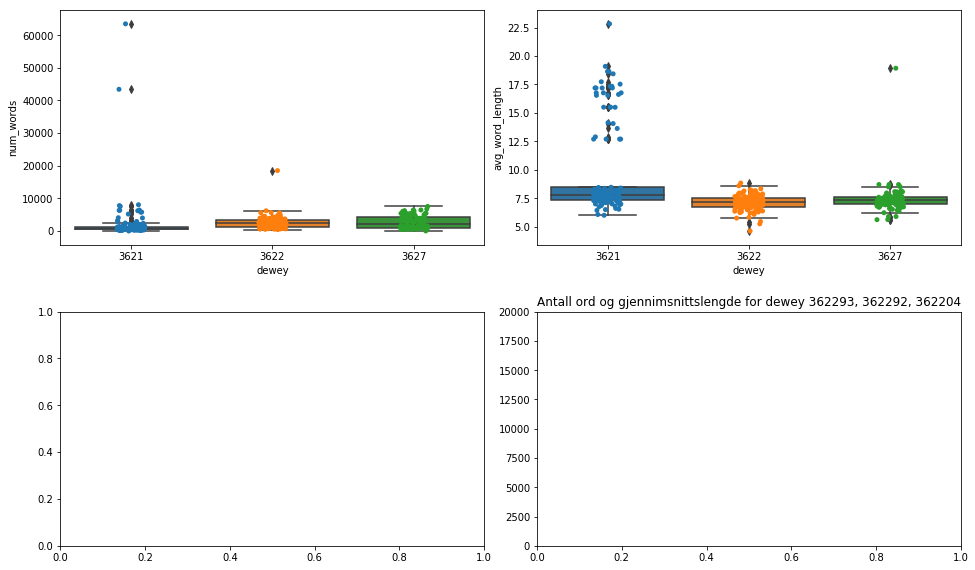

In [297]:

deweys21 = ["3621", "3622", "3627"]
df_2_1 = articles.loc[articles['dewey'].isin(deweys21)].copy()
df_2_1["num_words"] = df_2_1["text"].str.split().str.len()

df_2_1["char_length"] = df_2_1["text"].str.strip().str.len()
df_2_1["avg_word_length"] = df_2_1["char_length"]/df_2_1["num_words"]

fig, axs = plt.subplots(nrows = 2, ncols=2, sharey = False)
plt.title("Antall ord og gjennimsnittslengde for dewey 362293, 362292, 362204")
sns.boxplot(x = "dewey", y = "num_words", data =df_2_1, ax=axs[0,0])
sns.stripplot(x = "dewey", y = "num_words", data =df_2_1, jitter = True,edgecolor= "yellow", ax=axs[0,0])

sns.boxplot(x = "dewey", y = "avg_word_length", data =df_2_1, ax=axs[0,1])
sns.stripplot(x = "dewey", y = "avg_word_length", data =df_2_1, jitter = True,edgecolor= "yellow", ax=axs[0,1])

fig_size=[0,0]
fig_size[0] = 14
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
plt.ylim(0, 20000)
plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=2.0)
plt.show()

### Deltest 2.2
Plot av tekstlengde (ord) og gjennomsnittlig ordlengde for deweyene brukt i test 2.2

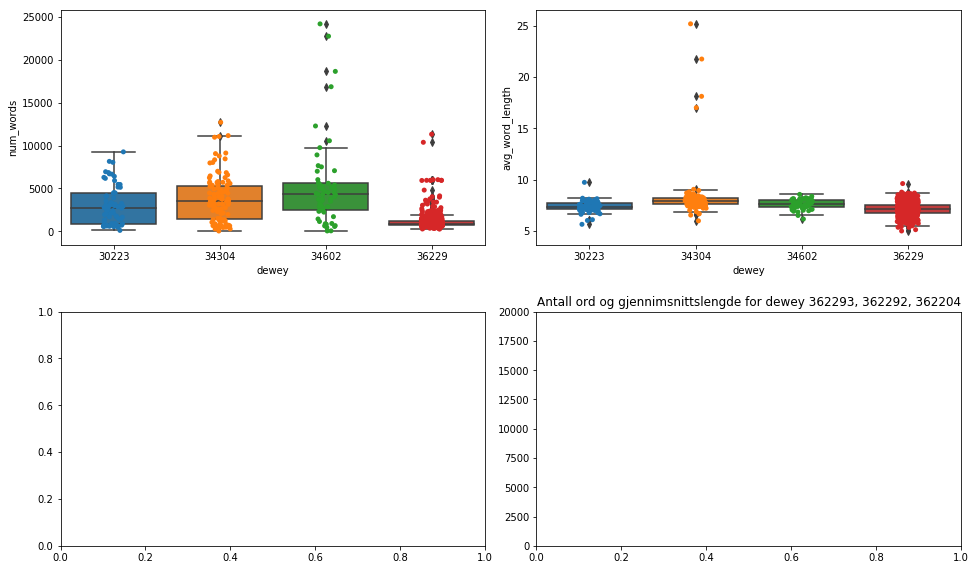

In [298]:
deweys22 = ["36229", "34304", "30223", "34602"]
df_2_2 = articles.loc[articles['dewey'].isin(deweys22)].copy()
df_2_2["num_words"] = df_2_2["text"].str.split().str.len()

df_2_2["char_length"] = df_2_2["text"].str.strip().str.len()
df_2_2["avg_word_length"] = df_2_2["char_length"]/df_2_2["num_words"]

fig, axs = plt.subplots(nrows = 2, ncols=2, sharey = False)
plt.title("Antall ord og gjennimsnittslengde for dewey 362293, 362292, 362204")
sns.boxplot(x = "dewey", y = "num_words", data =df_2_2, ax=axs[0,0])
sns.stripplot(x = "dewey", y = "num_words", data =df_2_2, jitter = True,edgecolor= "yellow", ax=axs[0,0])

sns.boxplot(x = "dewey", y = "avg_word_length", data =df_2_2, ax=axs[0,1])
sns.stripplot(x = "dewey", y = "avg_word_length", data =df_2_2, jitter = True,edgecolor= "yellow", ax=axs[0,1])

fig_size=[0,0]
fig_size[0] = 14
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
plt.ylim(0, 20000)
plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=2.0)
plt.show()

### Deltest 2.2
Plot av tekstlengde (ord) og gjennomsnittlig ordlengde for deweyene brukt i test 2.2

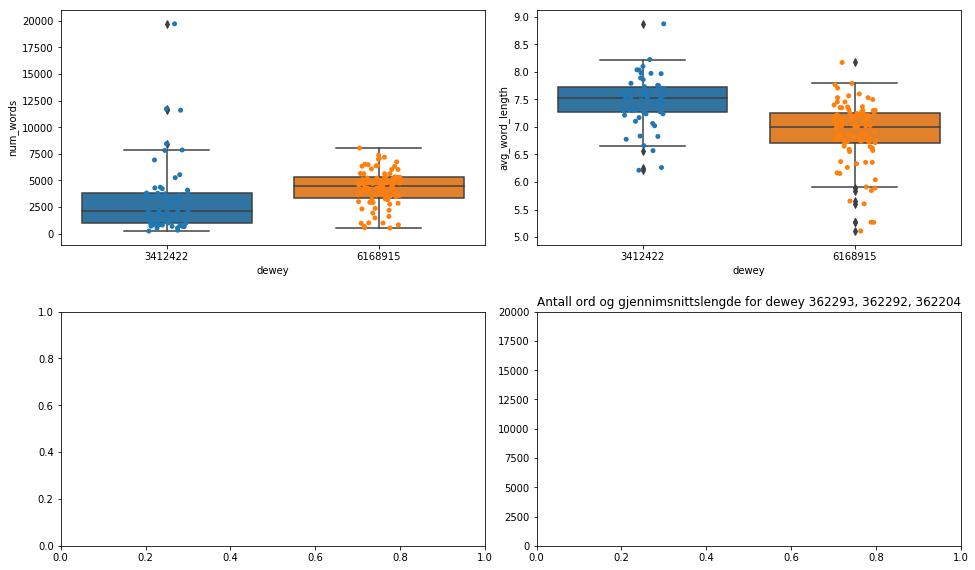

In [299]:
deweys23 = ["6168915", "3412422"]
df_2_3 = articles.loc[articles['dewey'].isin(deweys23)].copy()
df_2_3["num_words"] = df_2_3["text"].str.split().str.len()

df_2_3["char_length"] = df_2_3["text"].str.strip().str.len()
df_2_3["avg_word_length"] = df_2_3["char_length"]/df_2_3["num_words"]

fig, axs = plt.subplots(nrows = 2, ncols=2, sharey = False)
plt.title("Antall ord og gjennimsnittslengde for dewey 362293, 362292, 362204")
sns.boxplot(x = "dewey", y = "num_words", data =df_2_3, ax=axs[0,0])
sns.stripplot(x = "dewey", y = "num_words", data =df_2_3, jitter = True,edgecolor= "yellow", ax=axs[0,0])

sns.boxplot(x = "dewey", y = "avg_word_length", data =df_2_3, ax=axs[0,1])
sns.stripplot(x = "dewey", y = "avg_word_length", data =df_2_3, jitter = True,edgecolor= "yellow", ax=axs[0,1])

fig_size=[0,0]
fig_size[0] = 14
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
plt.ylim(0, 20000)
plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=2.0)
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


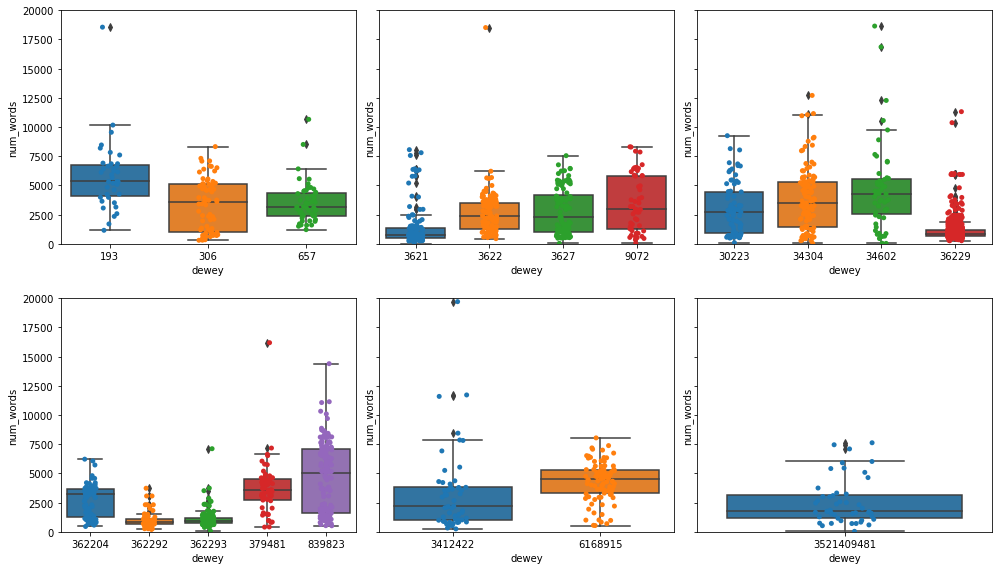

In [272]:

dewey7_df["num_words"] = dewey7_df["text"].str.split().str.len()
dewey6_df["num_words"] = dewey6_df["text"].str.split().str.len()
dewey5_df["num_words"] = dewey5_df["text"].str.split().str.len()
dewey4_df["num_words"] = dewey4_df["text"].str.split().str.len()

#print(dewey3_df["char_length"])

#dewey3_df.plot(x =dewey3_df["char_length"], style='o')
fig, axs = plt.subplots(nrows = 2, ncols=3, sharey = True)



sns.boxplot(x = "dewey", y = "num_words", data =dewey4_df, ax=axs[0,1])
sns.stripplot(x = "dewey", y = "num_words", data =dewey4_df, jitter = True,edgecolor= "yellow", ax=axs[0,1])

sns.boxplot(x = "dewey", y = "num_words", data =dewey5_df, ax=axs[0,2])
sns.stripplot(x = "dewey", y = "num_words", data =dewey5_df, jitter = True,edgecolor= "yellow", ax=axs[0,2])

sns.boxplot(x = "dewey", y = "num_words", data =dewey6_df, ax=axs[1,0])
sns.stripplot(x = "dewey", y = "num_words", data =dewey6_df, jitter = True,edgecolor= "yellow", ax=axs[1,0])

sns.boxplot(x = "dewey", y = "num_words", data =dewey7_df, ax=axs[1,1])
sns.stripplot(x = "dewey", y = "num_words", data =dewey7_df, jitter = True,edgecolor= "yellow", ax=axs[1,1])

sns.boxplot(x = "dewey", y = "num_words", data =dewey10_df, ax=axs[1,2])
sns.stripplot(x = "dewey", y = "num_words", data =dewey10_df, jitter = True,edgecolor= "yellow", ax=axs[1,2])
plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=2.0)
# Set figure width to 12 and height to 9
fig_size=[0,0]
fig_size[0] = 14
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
plt.ylim(0, 20000)
plt.show()


## Gjennomsnittlig ordlengde


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


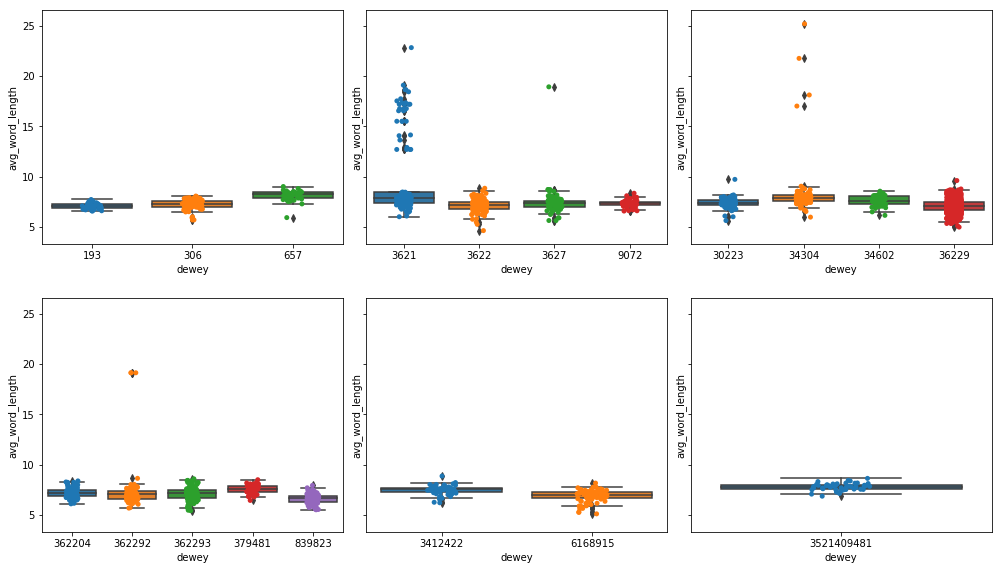

In [273]:
##La oss nå ta en kikk på gjennomsnittlig ordlengde for de forskjellige artiklene.
dewey10_df["char_length"] = dewey10_df["text"].str.strip().str.len()
dewey10_df["avg_word_length"] = dewey10_df["char_length"]/dewey10_df["num_words"]

dewey7_df["char_length"] = dewey7_df["text"].str.strip().str.len()
dewey7_df["avg_word_length"] = dewey7_df["char_length"]/dewey7_df["num_words"]

dewey6_df["char_length"] = dewey6_df["text"].str.strip().str.len()
dewey6_df["avg_word_length"] = dewey6_df["char_length"]/dewey6_df["num_words"]

dewey5_df["char_length"] = dewey5_df["text"].str.strip().str.len()
dewey5_df["avg_word_length"] = dewey5_df["char_length"]/dewey5_df["num_words"]

dewey4_df["char_length"] = dewey4_df["text"].str.strip().str.len()
dewey4_df["avg_word_length"] = dewey4_df["char_length"]/dewey4_df["num_words"]




fig, axs = plt.subplots(nrows = 2, ncols=3, sharey = True)


sns.boxplot(x = "dewey", y = "avg_word_length", data =dewey4_df, ax=axs[0,1])
sns.stripplot(x = "dewey", y = "avg_word_length", data =dewey4_df, jitter = True,edgecolor= "yellow", ax=axs[0,1])

sns.boxplot(x = "dewey", y = "avg_word_length", data =dewey5_df, ax=axs[0,2])
sns.stripplot(x = "dewey", y = "avg_word_length", data =dewey5_df, jitter = True,edgecolor= "yellow", ax=axs[0,2])

sns.boxplot(x = "dewey", y = "avg_word_length", data =dewey6_df, ax=axs[1,0])
sns.stripplot(x = "dewey", y = "avg_word_length", data =dewey6_df, jitter = True,edgecolor= "yellow", ax=axs[1,0])

sns.boxplot(x = "dewey", y = "avg_word_length", data =dewey7_df, ax=axs[1,1])
sns.stripplot(x = "dewey", y = "avg_word_length", data =dewey7_df, jitter = True,edgecolor= "yellow", ax=axs[1,1])

sns.boxplot(x = "dewey", y = "avg_word_length", data =dewey10_df, ax=axs[1,2])
sns.stripplot(x = "dewey", y = "avg_word_length", data =dewey10_df, jitter = True,edgecolor= "yellow", ax=axs[1,2])
plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=2.0)
# Set figure width to 12 and height to 9
fig_size=[0,0]
fig_size[0] = 14
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
#plt.ylim(0, 20000)
plt.show()
